In [111]:
import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import models,layers

import pandas as pd
from sklearn import preprocessing

In [79]:
data=pd.read_csv("spam.csv")
data.head(3)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [80]:
data.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [81]:
spam_data=data[data["Category"]=="spam"]
spam_data.shape

(747, 2)

In [82]:
ham_data=data[data["Category"]=="ham"]
ham_data.shape

(4825, 2)

In [83]:
ham_data_updated=ham_data.sample(spam_data.shape[0])

In [84]:
new_data=pd.concat([ham_data_updated,spam_data])

In [85]:
new_data.describe()

,Category,Message
count,1494,1494
unique,2,1378
top,ham,"Sorry, I'll call later"
freq,747,6


In [86]:
new_data["Category"].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [87]:
label_encoder = preprocessing.LabelEncoder()

In [88]:
new_data["category"]= label_encoder.fit_transform(new_data["Category"])

In [94]:
new_data.head()

,Category,Message,category
931,ham,I'm really sorry i won't b able 2 do this frid...,0
130,ham,K..k:)how much does it cost?,0
1689,ham,Nan sonathaya soladha. Why boss?,0
4413,ham,If i said anything wrong sorry de:-),0
5276,ham,Dunno leh cant remember mayb lor. So wat time ...,0


In [89]:
from sklearn.model_selection import train_test_split

In [92]:
new_data["Category"].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [95]:
X_train,X_test,y_train,y_test=train_test_split(new_data["Message"],new_data["category"],stratify=new_data["category"])

In [97]:
X_train

4577    Congratulations ur awarded 500 of CD vouchers ...
5497    SMS SERVICES. for your inclusive text credits,...
2654    Sorry da:)i was thought of calling you lot of ...
2254                         Lol enjoy role playing much?
397     Was actually sleeping and still might when u c...
                              ...                        
1778    Buy Space Invaders 4 a chance 2 win orig Arcad...
2422    Err... Cud do. I'm going to  at 8pm. I haven't...
4864    Bored housewives! Chat n date now! 0871750.77....
2070    Eerie Nokia tones 4u, rply TONE TITLE to 8007 ...
5181    K sure am in my relatives home. Sms me de. Pls:-)
Name: Message, Length: 1120, dtype: object

In [99]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [102]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351695, -0.5132727 , -0.88845736, ..., -0.74748874,
        -0.75314736,  0.91964495],
       [-0.87208354, -0.50543964, -0.94446677, ..., -0.8584749 ,
        -0.7174534 ,  0.88082975]], dtype=float32)>

In [104]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [108]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[2]])

array([[0.99540985]], dtype=float32)

In [112]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [114]:
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

In [115]:
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [116]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [117]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [118]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [119]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 169s 5s/step - loss: 0.6359 - accuracy: 0.6375 - precision: 0.6400 - recall: 0.6286
Epoch 2/10
35/35 [==============================] - 162s 5s/step - loss: 0.5058 - accuracy: 0.8152 - precision: 0.8102 - recall: 0.8232
Epoch 3/10
35/35 [==============================] - 161s 5s/step - loss: 0.4399 - accuracy: 0.8455 - precision: 0.8241 - recall: 0.8786
Epoch 4/10
35/35 [==============================] - 161s 5s/step - loss: 0.3858 - accuracy: 0.8705 - precision: 0.8673 - recall: 0.8750
Epoch 5/10
35/35 [==============================] - 171s 5s/step - loss: 0.3588 - accuracy: 0.8714 - precision: 0.8662 - recall: 0.8786
Epoch 6/10
35/35 [==============================] - 169s 5s/step - loss: 0.3324 - accuracy: 0.8884 - precision: 0.8783 - recall: 0.9018
Epoch 7/10
35/35 [==============================] - 151s 4s/step - loss: 0.3112 - accuracy: 0.9018 - precision: 0.8906 - recall: 0.9161
Epoch 8/10
35/35 [==============================

In [120]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 57s 5s/step - loss: 0.2933 - accuracy: 0.8904 - precision: 0.8380 - recall: 0.9679


[0.29332634806632996,
 0.8903743028640747,
 0.8379629850387573,
 0.9679144620895386]

In [122]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 55s 4s/step


In [123]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,

In [124]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[152,  35],
       [  6, 181]], dtype=int64)

Text(33.0, 0.5, 'Truth')

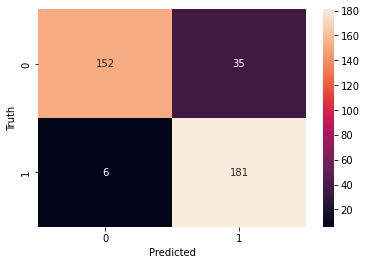

In [125]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [126]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88       187
           1       0.84      0.97      0.90       187

    accuracy                           0.89       374
   macro avg       0.90      0.89      0.89       374
weighted avg       0.90      0.89      0.89       374



In [127]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.75572   ],
       [0.8611206 ],
       [0.82896656],
       [0.26999864],
       [0.13372394]], dtype=float32)